# An analysis of our electrical consumption
## Hypothesis:
1. Consumption is higher on weekend vs weekdays
1. Sunshine days will have less net consumption (leverage different data frame)
1. Winter months (due to lower sunshine hours) will have higher net consumption than summer months

## Questions: 
1. Would a battery make any difference and if so, then how much?
1. Are there months/days that the battery would not get used


## Ideas
1. Count the amount of 0 net consumption per day 

In [2]:
import pandas as pd
import numpy as np
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
consumption = pd.read_csv('../data/elforbrug/elforbrug_2020_2021.csv',delimiter=';',parse_dates=['Fradato'], decimal=',')
consumption['HourOfDay'] = consumption['Fradato'].dt.hour
consumption.head()

,Fradato,Tildato,Forbrug,HourOfDay
0,2020-02-21 00:00:00,21-02-2020 01:00,0.31,0
1,2020-02-21 01:00:00,21-02-2020 02:00,0.83,1
2,2020-02-21 02:00:00,21-02-2020 03:00,0.40,2
3,2020-02-21 03:00:00,21-02-2020 04:00,0.40,3
4,2020-02-21 04:00:00,21-02-2020 05:00,0.37,4


# Look at hour of day for consumption trends

## Visualise consumption distribution for a single hour slice of the day

## Show heatmap of consumption split on day of week (0 = Monday) and hour of day
Here showing average

<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

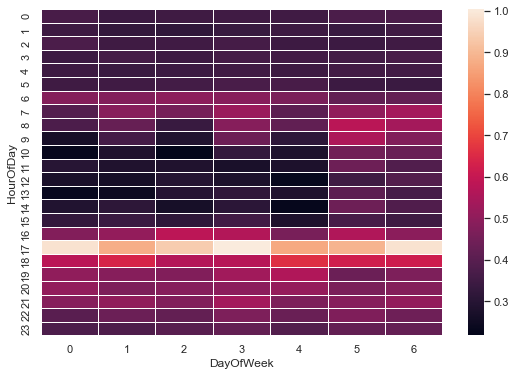

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

#Annotate day of week
consumption['NamedDayOfWeek'] = consumption['Fradato'].dt.day_name()
consumption['DayOfWeek'] = consumption['Fradato'].dt.dayofweek

conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.average )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=False, fmt='f', linewidths=.5, ax=ax)

Here showing aggregate value

<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

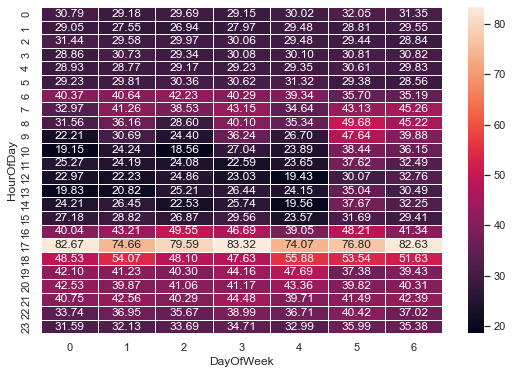

In [7]:
conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.sum )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=True, fmt='.2f', linewidths=.5, ax=ax)

Add day of week to figure out how consumption splits per day and type of day

In [ ]:

sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

#seriesmap = consumption.g.map(ord)
setHourOfDay = consumption['HourOfDay']
#seriesmap = setHourOfDay
#consumption['x'] += seriesmap

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(24, rot=-.25, light=.7)
g = sns.FacetGrid(consumption, row='HourOfDay', hue='HourOfDay', aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'HourOfDay',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'HourOfDay', clip_on=False, color='w', lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,
            ha='left', va='center', transform=ax.transAxes)


g.map(label, 'HourOfDay')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)

In [ ]:
#https://seaborn.pydata.org/examples/kde_ridgeplot.html
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)